##Working with LSST Data

This notebook gives sample weak_sauce tests on an LSST ultraflat (500 co-added frames; 625nm; light level = 75ke-; full well = 170ke-). The included data file is a single amplifier (with a 50 pixel border removed--TODO: later look at edge effects that BNL, SAWG are so anxious to model.)

In [1]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

full_amp_img = np.load('../data/lsst_ultraflat_75ke_amp3.npy')
full_detrend_img = weak_sauce.data_tools.detrend(full_amp_img)

We need to detrend (high-pass filter) over the entire image to kill any illumination variation (bad flat) and large-scale pixel-area variations we're not interested in, but for these first tests we'll focus on a 50x50 pixel region I've chosen to not have any bad pixels.

In [2]:
test_img = full_amp_img[1000:1050,200:250]
test_detrend = full_detrend_img[1000:1050,200:250]

Let's visualize and get basic stats on this cutout (all units are in ADU):

Local light level: 36836.8240943
Local total noise: 138.974576512
Local small-scale noise: 125.238363735


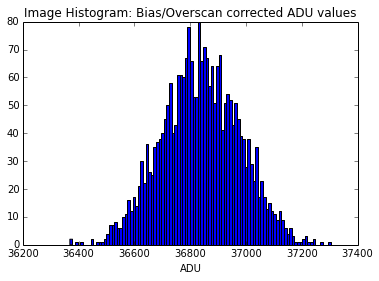

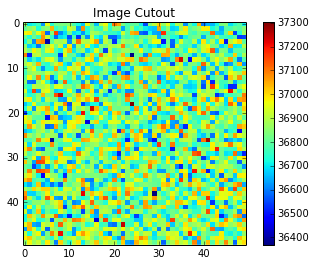

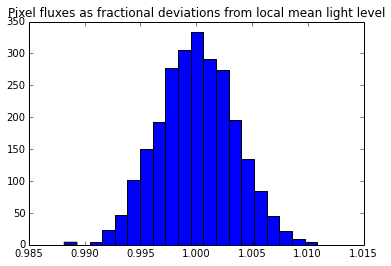

In [3]:
plt.title('Image Histogram: Bias/Overscan corrected ADU values')
_ = plt.hist(test_img.flatten(),bins=100)
plt.xlabel('ADU')
plt.figure()
plt.title('Image Cutout')
plt.imshow(test_img,interpolation='None')
plt.colorbar()
local_mean = np.mean(test_img)
local_std_no_detrend = np.std(test_img)
local_std_w_detrend = np.std(test_detrend)
print 'Local light level:', local_mean
print 'Local total noise:', local_std_no_detrend
print 'Local small-scale noise:', local_std_w_detrend
data_rel_flux_map = test_detrend/local_mean+1
plt.figure()
plt.title('Pixel fluxes as fractional deviations from local mean light level')
_ = plt.hist(data_rel_flux_map.flatten(),bins=20)

Below we illustrate the use of the two main functions in data_tools.py that produce the pixel-neighbor correlation maps we are interested in:

[[  -0.2    4.    -0.1    0.7   -1.6]
 [  -0.6   -8.6  -27.8   -7.4   -0.3]
 [  -5.3  -10.   100.   -10.    -5.3]
 [  -0.3   -7.4  -27.8   -8.6   -0.6]
 [  -1.6    0.7   -0.1    4.    -0.2]]


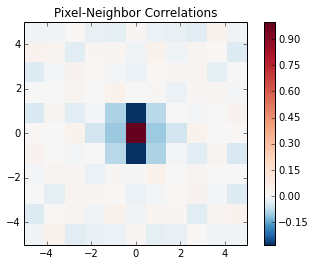

In [4]:
test_arr = weak_sauce.data_tools.makeCorr(test_detrend)

vert corr: (-0.38577354378404433, 1.2228106370357518e-82)
horiz corr: (-0.14179627605453896, 8.0812501562009035e-12)
diag corr: (-0.17936649978830199, 4.1222486259807989e-18)


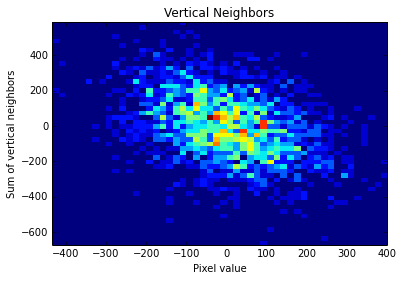

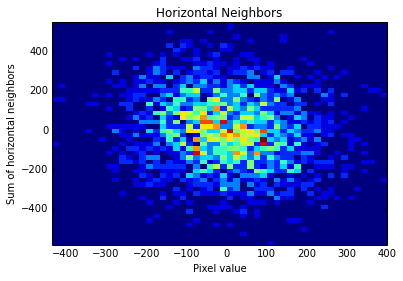

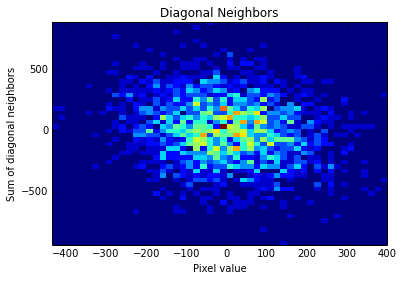

In [5]:
weak_sauce.data_tools.neighborScatter(test_detrend)

##Toy Models in New Framework

In [6]:
from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source

In [7]:
mover = UniformGaussianMover(mu_x=0, mu_y=0, sigma_xx=0.01, sigma_yy=0.01, sigma_xy=0.0)
source = Source(num_x=30)
mg = MoveableGrid(source,mover)

(<matplotlib.figure.Figure at 0x10963fb90>,
 <matplotlib.axes.AxesSubplot at 0x10c732f50>)

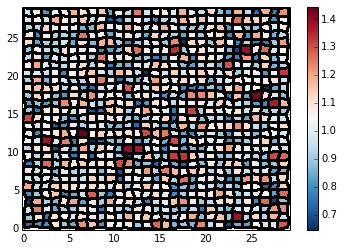

In [8]:
mg.step()
mg.plot_real_grid()

[[   4.     6.9    4.2   -1.3    3.3]
 [  -0.5  -25.1    1.5  -24.8   -3. ]
 [   0.8   -4.1  100.    -4.1    0.8]
 [  -3.   -24.8    1.5  -25.1   -0.5]
 [   3.3   -1.3    4.2    6.9    4. ]]


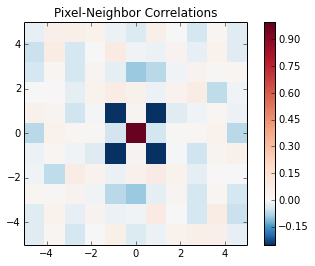

In [9]:
_ = weak_sauce.data_tools.makeCorr(mg.source.fluxes-np.mean(mg.source.fluxes))

There's a good amount of shot noise (only did 30x30 for visualization purposes), but the overall structure of gaussian vertex shifts producing diagonal negative correlations agrees with what I saw before!

##Fitting a pixel size model to an LSST ultraflat

In [10]:
from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter

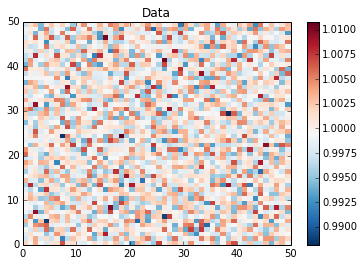

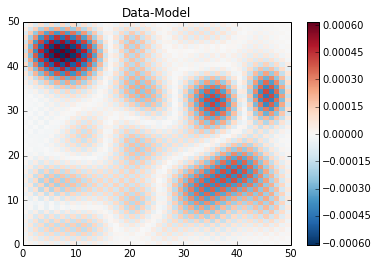

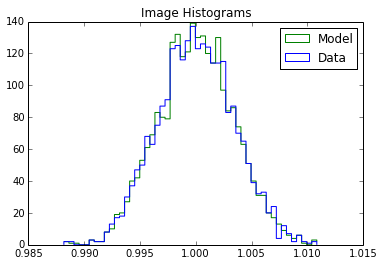

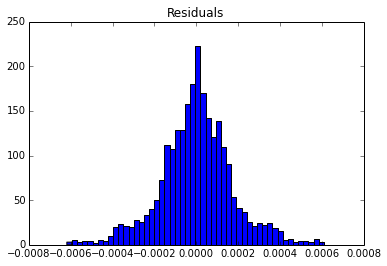

In [11]:
data_like_mover = UniformIlluminationMover()
data_like_source = Source(num_x=51) 
data_like_source.fluxes += 1 #fit to flat field
data_mg = MoveableGrid(data_like_source,data_like_mover)
fitter = FlatFitter(data_rel_flux_map, luminosity=1)
oldlnlike = -10000
lnlike = -10000
for stepnum in xrange(10000):
    fitter(data_mg.source, step_size=1e-3)
    lnlike, oldlnlike = fitter.lnlike(data_mg.source.vertices, data_mg.source.fluxes), lnlike
    if lnlike < oldlnlike:
        break
data_mg.source.plot(data_rel_flux_map, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')
data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')
plt.figure()
plt.title('Image Histograms')
_ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)

##Does our fit reproduce the correlations observed in data?

DATA
[[  -0.2    4.    -0.1    0.7   -1.6]
 [  -0.6   -8.6  -27.8   -7.4   -0.3]
 [  -5.3  -10.   100.   -10.    -5.3]
 [  -0.3   -7.4  -27.8   -8.6   -0.6]
 [  -1.6    0.7   -0.1    4.    -0.2]]
MODEL
[[  -1.     5.    -1.1    1.6   -2.5]
 [   0.3   -9.8  -27.1   -8.5    0.6]
 [  -6.3   -9.   100.    -9.    -6.3]
 [   0.6   -8.5  -27.1   -9.8    0.3]
 [  -2.5    1.6   -1.1    5.    -1. ]]


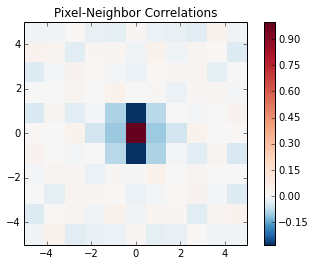

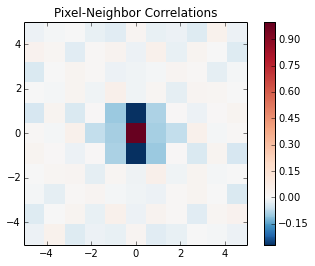

In [12]:
print 'DATA'
data_corr = weak_sauce.data_tools.makeCorr(data_rel_flux_map)
print 'MODEL'
model_corr = weak_sauce.data_tools.makeCorr(data_mg.source.fluxes)

Looks good qualitatively; what about the residuals?

<matplotlib.colorbar.Colorbar instance at 0x10cb34248>

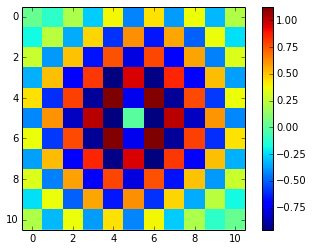

In [13]:
plt.imshow(100*(data_corr-model_corr),interpolation='None')
plt.colorbar()

The correlations obtained agree to within 1 percent! Not exactly sure why the residual has such a strange pattern... Chris' idea: if the model overshoots on a single pixel, then it must undershoot on its neighbors (it's a zero-sum game). 

vert corr: (-0.37667323573430639, 1.4319580161899136e-78)
horiz corr: (-0.12832330376863721, 6.3395368476643846e-10)
diag corr: (-0.2064268965390669, 1.3619740255843702e-23)


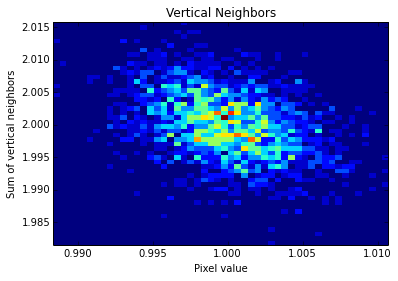

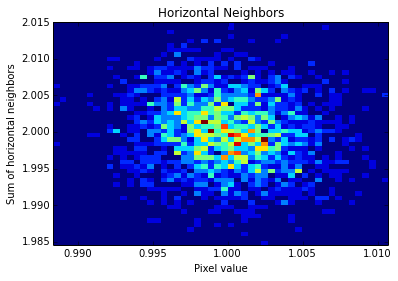

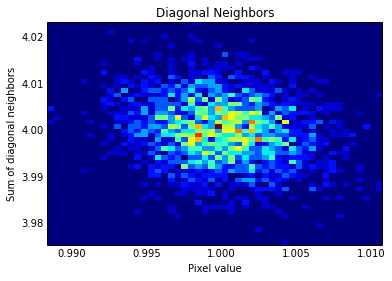

In [14]:
weak_sauce.data_tools.neighborScatter(data_mg.source.fluxes)

Can still see negative correlations in the pixel-neighbor scatterplots

##Correlations in Residuals?

[[  85.6  -89.7   91.4  -89.4   85. ]
 [ -91.2   96.1  -97.5   96.   -90.8]
 [  93.3  -98.   100.   -98.    93.3]
 [ -90.8   96.   -97.5   96.1  -91.2]
 [  85.   -89.4   91.4  -89.7   85.6]]


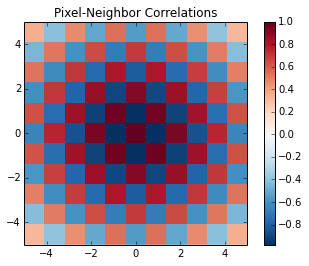

In [15]:
resid = data_rel_flux_map - data_mg.source.fluxes 
resid_corr = weak_sauce.data_tools.makeCorr(resid)

Huge reversing pattern in the correlation function of the residual, but this makes sense given the lockstep sign-flipping behavior in the residual map...

##Are we actually converging on a unique solution?

At first glance, this seems like an ill-posed inverse problem: for an $N \times M$ grid we are trying to fit, there are $2*(N+1)(M+1) = 2NM + 2N + 2M + 2$ degrees of freedom (two for each vertex) and only $MN$ constraining fluxes. 

Let's test if our problem satisfies the Hadamard condition that the answer be *continuously* dependent on the inputs

(<matplotlib.figure.Figure at 0x10d4f3850>,
 <matplotlib.axes.AxesSubplot at 0x10d198710>)

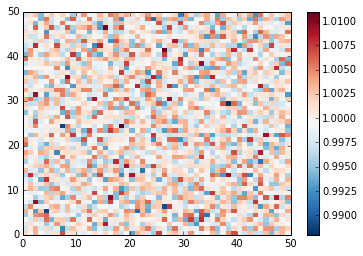

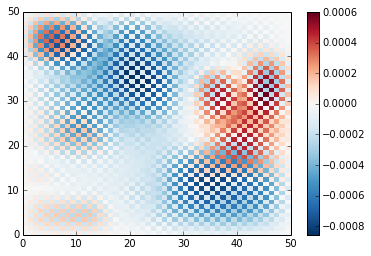

In [19]:
mover = UniformGaussianMover(mu_x=0, mu_y=0, sigma_xx=0.01, sigma_yy=0.01, sigma_xy=0.0)
source = Source(num_x=51)
source.fluxes+=1
perturbed_mg = MoveableGrid(source,mover)
perturbed_mg.step() #perturb the initial conditions

fitter = FlatFitter(data_rel_flux_map, luminosity=1)
oldlnlike = -10000
lnlike = -10000
for stepnum in xrange(50000):
    fitter(perturbed_mg.source, step_size=1e-3)
    lnlike, oldlnlike = fitter.lnlike(perturbed_mg.source.vertices, perturbed_mg.source.fluxes), lnlike
    if lnlike < oldlnlike:
        break
        
perturbed_mg.source.plot(perturbed_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
#plot the difference between the perturbed and unperturbed fit.
data_mg.source.plot(data_mg.source.fluxes-perturbed_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0}) 

Seems like you can get as close to previous (unperturbed) answer as the unperturbed answer gets to data...good sign? More systematic grid search is needed--good motivation for me to learn parallel ipython!

Is flux conserved? Not necessarily, but that makes sense--the boundaries of the chip are unconstrained, so the total flux (area) can easily change...

In [21]:
(np.sum(data_mg.source.fluxes)-np.sum(data_rel_flux_map))/2500

7.6108113462396435e-07

Of course, having said that and running it again, it now seems pretty strongly conserved...

##Create fake data from LSST model--try to recover fit

(<matplotlib.figure.Figure at 0x10c65e610>,
 <matplotlib.axes.AxesSubplot at 0x10c79f6d0>)

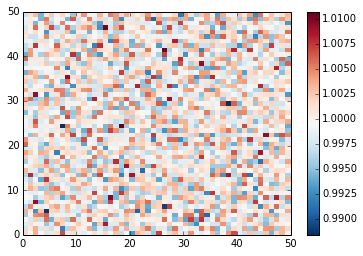

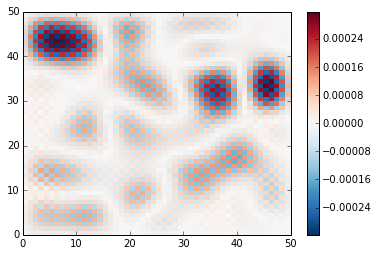

In [22]:
data_like_mover = UniformIlluminationMover()
data_like_source = Source(num_x=51) 
data_like_source.fluxes += 1 #fit to flat field
data_mg2 = MoveableGrid(data_like_source,data_like_mover) #what we'll fit to the previous fit
fitter = FlatFitter(data_mg.source.fluxes, luminosity=1)
oldlnlike = -10000
lnlike = -10000
for stepnum in xrange(10000):
    fitter(data_mg2.source, step_size=1e-3)
    lnlike, oldlnlike = fitter.lnlike(data_mg2.source.vertices, data_mg2.source.fluxes), lnlike
    if lnlike < oldlnlike:
        break
data_mg2.source.plot(data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
data_mg2.source.plot(data_mg2.source.fluxes - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})

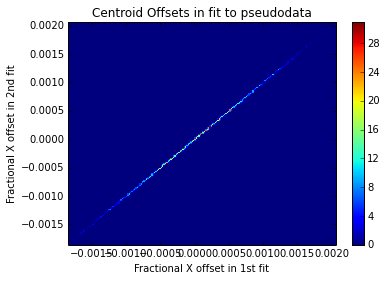

In [40]:
from matplotlib.colors import LogNorm
ideal_grid = Source(num_x=51)
_ = plt.hist2d((data_mg.source.centroids[:,:,0]-ideal_grid.centroids[:,:,0]).flatten(),
               (data_mg2.source.centroids[:,:,0]-ideal_grid.centroids[:,:,0]).flatten(),bins=200)
plt.colorbar()
plt.title('Centroid Offsets in fit to pseudodata')
plt.xlabel('Fractional X offset in 1st fit')
plt.ylabel('Fractional X offset in 2nd fit')

##Fitting to pseudodata from other fits seems to work!